# Posthoc Inference on Contrasts

In this notebook, we provide examples of how to run posthoc inference to infer on contrasts in the linear model.

## Set Up

#### Import the required python packages.

In [23]:
import numpy as np
import numpy.matlib as npm
import sys
import matplotlib.pyplot as plt 

sys.path.insert(0, 'C:\\Users\\12SDa\\global\\Intern\\SanSouciCode')
import sanssouci as ss

sys.path.insert(0, 'C:\\Users\\12SDa\\davenpor\\davenpor\\Toolboxes\\pyrft' )
import pyrft as pr

#### Initialize the example

In [20]:
# Set the dimension of the example and the number of subjects
Dim = (50,50); N = 30; m = np.prod(Dim)

# Generate the category vector and obtain the corresponding design matrix
from sklearn.utils import check_random_state
rng = check_random_state(101)
categ = rng.choice(3, N, replace = True)
X = pr.groupX(categ); 

# Specify the contrast matrix (here 2 contrasts are chosen)
C = np.array([[1,-1,0],[0,1,-1]]); 

# Calulate the number contrasts
L = C.shape[0]

# Calculate the number of p-values generated (L for each voxels)
npvals = m*L

# Generate a white noise field
lat_data = pr.wfield(Dim,N)

### Add signal to the field

In [3]:
# Obtain the locations where the category is 2
w2 = np.where(categ==2)[0]

# Initialize the spatial signal
pi0 = 0.9  # proportion of noise (true null hypotheses)
p0 = int(np.round(pi0*m))
signal = np.zeros(m)
signal[(p0+1):m] = 1
signal = signal.reshape(Dim)

# Add the signal to the field
for I in np.arange(len(w2)):
    lat_data.field[:,:,w2[I]] = lat_data.field[:,:,w2[I]] + signal

## Posthoc Inference

### Bootstrapping the Data

Bootstrapping is performed using the residuals of the linear model. This gives test-statistics that have the same asymptotic distribution as the limiting test-statistic (under the null). See Eck 2017 and Freedman 1981 for further details. In our context we use these to obtain bootstrapped pivotal statistics which allow us to obtain asymptotic JER control.

In [21]:
# Specify the number of bootstraps to use
B = 100

# Run the bootstrapped algorithm
minPperm, orig_pvalues, pivotal_stats, bs = pr.boot_contrasts(lat_data, X, C, B, ss.t_inv_linear, True, 1)

(5000, 100)
(1, 5000)


### Plotting the p-values

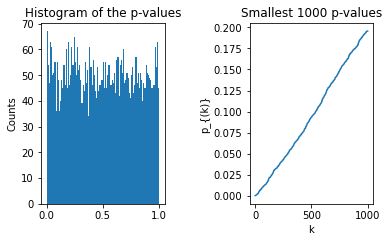

In [11]:
pvals = np.sort(np.ravel(orig_pvalues.field))

figure, axes = plt.subplots(nrows=1, ncols=2) 
plt.subplot(121)
plt.hist(np.ravel(orig_pvalues.field), 100);
plt.title('Histogram of the p-values');
plt.ylabel('Counts');

plt.subplot(122)
plt.plot(pvals[:np.min([1000, npvals])])
plt.title('Smallest 1000 p-values')
plt.xlabel('k')
plt.ylabel('p_{(k)}')

figure.tight_layout(pad=3.0)

### Lambda Calibration

Using the bootstrapped pivotal_stats that we have calculated we can choose a value lambda that is the (alpha)% quantile (for some 0 < alpha < 1) of the distribution in order to provide asymptotic JER control at a level alpha.

In [237]:
# Choose the confidence level
alpha = 0.1

# Obtain the lambda calibration
lambda_quant = np.quantile(pivotal_stats, alpha)
print('Lambda Quantile:', lambda_quant)

# Calculate the number of voxels in the mask
m = np.sum(lat_data.mask[:])

# Gives t_k^L(lambda) = lambda*k/m for k = 1, ..., m
thr = ss.t_linear(lambda_quant, np.arange(1,m+1), m)

Lambda Quantile: 0.2400582912354121


### PostHoc Bound

For a chosen subset of voxels, provide a bound on the number of true null hypotheses within that subset. 

In [238]:
# Get the first 10 pvalues (or any subset of the p-values)
subset_pvals = np.sort(np.ravel(orig_pvalues.field))[:10]

# Compute an upper bound on the number of null hypotheses
bound = ss.max_fp(subset_pvals, thr)
print('FP Upper Bound on subset:', bound)

FP Upper Bound on subset: 4.0


### Confidence Envelopes

In [239]:
# These are the confidence envelopes. I.e. for i = 1:npvals, max_FP[i-1] is the upper bound on the number of 
# false positives that occur within the set [p[0], \dots, p[i-1]] if you were to reject all elements of that set.
max_FP = ss.curve_max_fp(subset_pvals, thr) # Confidence envelope on the chosen subset
print(max_FP)
max_FP = ss.curve_max_fp(pvals, thr) # Confidence envelope on all of them
print(max_FP[0:200])

[0. 0. 0. 0. 0. 1. 1. 2. 3. 4.]
[  0.   0.   0.   0.   0.   1.   1.   2.   3.   4.   5.   6.   7.   8.
   9.  10.  11.  12.  13.  13.  14.  15.  16.  17.  18.  19.  20.  21.
  22.  23.  24.  25.  26.  27.  27.  27.  27.  28.  28.  29.  30.  30.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.
  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.
  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.
  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.
  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100.
 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114.
 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128.
 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142.
 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156.
 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170.
 171. 172. 173. 174. 175. 176. 177. 178. 179.

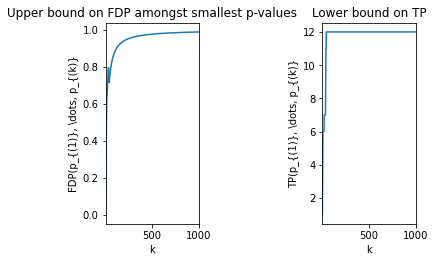

<Figure size 1.4472e+06x720 with 0 Axes>

In [249]:
# Generate the vector [0,...,npvals]
one2npvals = np.arange(1, npvals+1)

# Choose the number of the lowest p-values to look at
lowestnumber = np.min([1000, npvals])

# Dividing the envelope by the number of elements in the set gives a bound on the false discovery proportion
max_FDP = max_FP[0:lowestnumber]/ one2npvals[0:lowestnumber] 
min_TP = one2npvals[0:lowestnumber] - max_FP[0:lowestnumber]
figure, axes = plt.subplots(nrows=1, ncols=2) 
plt.subplot(121)
plt.plot(max_FDP)
plt.title('Upper bound on FDP amongst smallest p-values')
plt.xlim(1, lowestnumber)
plt.xlabel('k')
plt.ylabel('FDP(p_{(1)}, \dots, p_{(k)}')
plt.subplot(122)
plt.plot(min_TP)
plt.title('Lower bound on TP')
plt.xlim(1, lowestnumber)
plt.xlabel('k')
plt.ylabel('TP(p_{(1)}, \dots, p_{(k)}')
plt.figure(figsize=(20100,10))
figure.tight_layout(pad=2.0)


### Bootstrap paths

(1.0, 5000.0)

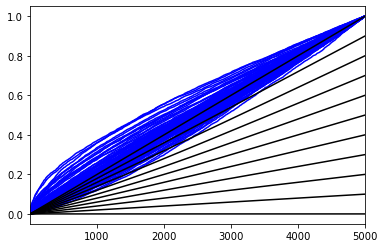

In [22]:
for b in np.arange(B):
    plt.plot(bs[:,b],color="blue")
    
# Calculate reference families
m = bs.shape[0]
lamb = np.arange(11)/10
k = np.arange(m+1)

for l in np.arange(len(lamb)):
    plt.plot(lamb[l]*k/m,color="black")
    
plt.xlim(1, m)
plt.xlabel('k')
plt.ylabel('p_{b,(k)}')